# Importación de librerías

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

# Reestrucutrar el DataSet

In [2]:
# Lectura de labels para identificar los artistas y sy género del Dataset original
df = pd.read_csv('labels.csv')

In [6]:
# Creación de diccionario para asignar al artista con su género
artist_genre = dict(zip(df['name'], df['genre']))

Partiendo de la carpeta *original* (donde se encuentra el dataset) y la carpeta *images* (donde será reestructurado el dataset), se crean nuevas subcarpetas en *images* que corresponde al género del artista, se cambiará la estructura del dataset de Artista/Obras a Género/Obras, contando con 11 géneros artísticos de base y añadiendo un doceavo género (*Anime*) una vez haya concluido el proceso de reestrucutración.

In [20]:
path = "/"
base_dir = 'images'
original =  'original'

for folder in os.listdir(original):
    folder_path = os.path.join(original, folder)
    
    if os.path.isdir(folder_path):
        artist = folder
        
        if artist in artist_genre:
            genre = artist_genre[artist]
            new_folder_path = os.path.join(base_dir, genre)
            os.makedirs(new_folder_path, exist_ok=True)

            # Mover contenido de la carpeta artista a la nueva ubicación
            for file in os.listdir(folder_path):
                if file.endswith('.jpg'):
                    file_path = os.path.join(folder_path, file)
                    shutil.copy(file_path, new_folder_path)

# Split de test y train

Se hace un split de 80% para *train* y 20% para *test*, este se guardará en la carpeta *model* previamente creada.

In [5]:
path = "/"
base_dir = 'model'
images =  'images'
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir, 'test')

In [33]:
train_split = 0.8 

# Lista de carpetas en el dataset images
folder_group = [name for name in os.listdir(images) if os.path.isdir(os.path.join(images, name))]

# Crear las carpetas de train y test
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterar sobre cada carpeta de los grupos
for folder in folder_group:
    folder_path = os.path.join(images, folder)
    images_list = os.listdir(folder_path)
    
    # Número de imágenes a incluir en test
    train_images_num = int(len(images_list) * train_split)
    
    # Mezclar las imágenes
    random.shuffle(images_list)
    
    # Dividir las imágenes en conjuntos de train y test
    train_list = images_list[:train_images_num]
    test_list = images_list[train_images_num:]

    # Crear subcarpetas en las carpetas de destino
    train_folder = os.path.join(train_dir, folder)
    test_folder = os.path.join(test_dir, folder)
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)
    
    # Mover las imágenes a las carpetas
    for image in train_list:
        origin = os.path.join(folder_path, image)
        destiny = os.path.join(train_folder, image)
        shutil.copy(origin, destiny)
    
    for image in test_list:
        origin = os.path.join(folder_path, image)
        destiny = os.path.join(test_folder, image)
        shutil.copy(origin, destiny)

# Data Augmentation

Se realiza un aumento de datos para el entrenamiento del modelo.

In [3]:
train_datagen = ImageDataGenerator(
							rescale = 1./255,
							rotation_range = 40,
							width_shift_range = 0.2,
							height_shift_range = 0.2,
							shear_range = 0.3,
							zoom_range = 0.3,
							horizontal_flip = True,)

In [6]:
train_generator = train_datagen.flow_from_directory(
							train_dir,
							target_size = (150, 150),
							batch_size = 8,
							class_mode ='categorical',)

Found 4979 images belonging to 12 classes.


In [7]:
test_datagen = ImageDataGenerator(1./255)
test_generator = test_datagen.flow_from_directory(
					test_dir,
					target_size = (150, 150),
					batch_size = 20,
					class_mode= 'categorical')

Found 1252 images belonging to 12 classes.


Muestra de imágenes modificadas.

(8, 150, 150, 3)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


<Figure size 640x480 with 0 Axes>

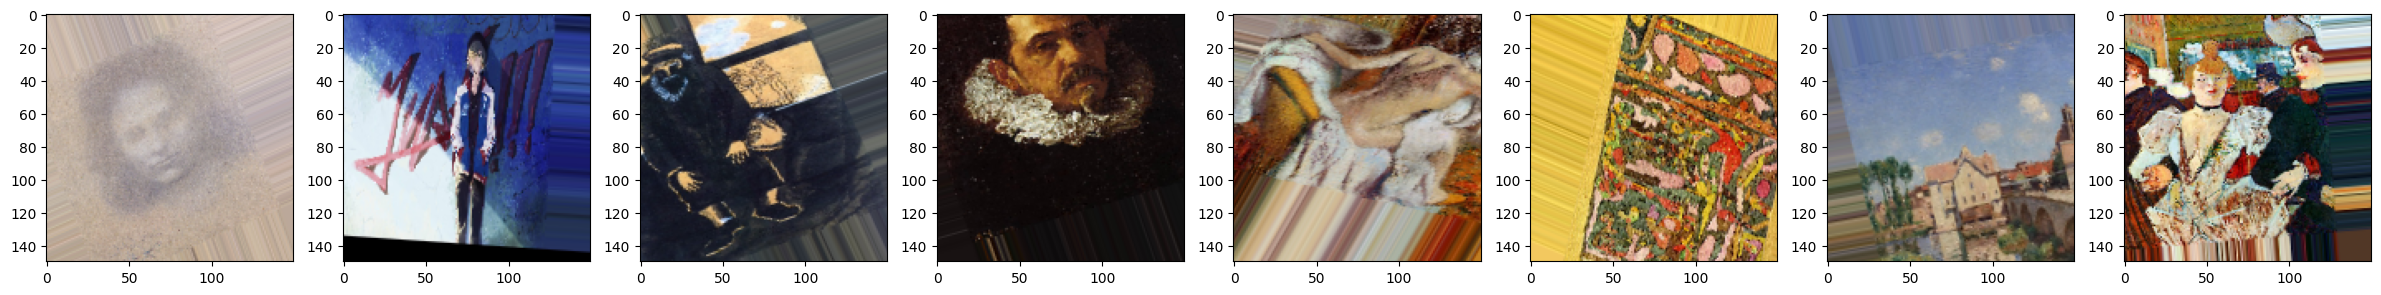

In [36]:
images , labels = train_generator[0]

print(images.shape)
print(labels)


plt.figure()
f, axarr = plt.subplots(1, images.shape[0], figsize=(30, 4)) 

for i in range(images.shape[0]) :  
  axarr[i].imshow(images[i])

# Modelo Base

Es un modelo Secuencial Categórico, cuenta con una capa Conv2D, una capa Flatten para que las imágenes se procesen en una sola línea, una capa densa con activación *relu* y una capa densa de 12 nodos (el número de géneros a clasificar) de activación *softmax*.

Como métricas se tiene el *Categorical Cross Entropy* para *Loss*, *RMSprop* como *optimizer* y *accuracy* para las *metrics*.

In [37]:
model = models.Sequential()
model.add(layers.Conv2D(10, (3, 3), activation="relu", input_shape = (150,150,3)))
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(12,activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
						optimizer=optimizers.RMSprop(learning_rate=2e-5),
						metrics=['acc'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 10)      280       
                                                                 
 flatten_3 (Flatten)         (None, 219040)            0         
                                                                 
 dense_6 (Dense)             (None, 256)               56074496  
                                                                 
 dense_7 (Dense)             (None, 12)                3084      
                                                                 
Total params: 56,077,860
Trainable params: 56,077,860
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
125/623 [=====>........................] - ETA: 3:23 - loss: 2.6293 - acc: 0.1060

c:\Users\quiqu\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\Image.py:2855: DecompressionBombWarning: Image size (91187250 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


623/623 [==============================] - 248s 396ms/step - loss: 2.4870 - acc: 0.1378
Epoch 2/10
623/623 [==============================] - 248s 397ms/step - loss: 2.3819 - acc: 0.1723
Epoch 3/10
623/623 [==============================] - 248s 398ms/step - loss: 2.3159 - acc: 0.2016
Epoch 4/10
623/623 [==============================] - 248s 398ms/step - loss: 2.2689 - acc: 0.2131
Epoch 5/10
623/623 [==============================] - 247s 397ms/step - loss: 2.2386 - acc: 0.2282
Epoch 6/10
623/623 [==============================] - 248s 398ms/step - loss: 2.2000 - acc: 0.2565
Epoch 7/10
623/623 [==============================] - 247s 397ms/step - loss: 2.1436 - acc: 0.2792
Epoch 8/10
623/623 [==============================] - 248s 398ms/step - loss: 2.1192 - acc: 0.2876
Epoch 9/10
623/623 [==============================] - 246s 394ms/step - loss: 2.0822 - acc: 0.2952
Epoch 10/10
623/623 [==============================] - 251s 403ms/step - loss: 2.0467 - acc: 0.3079


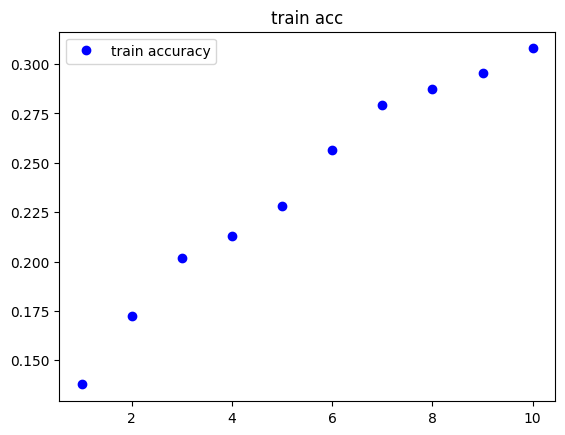

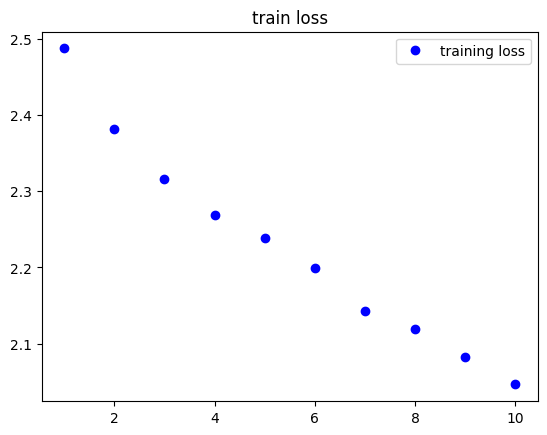

In [38]:
history = model.fit(
					train_generator, 
					epochs = 10)
				
			
acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.title('train acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.title('train loss')
plt.legend()

plt.show()

In [59]:
test_loss_base, test_acc_base = model.evaluate(test_generator, steps = 25)
print('\ntest acc :\n', test_acc_base)

25/25 [==============================] - 4s 142ms/step - loss: 249.8535 - acc: 0.2280

test acc :
 0.2280000001192093


# Segundo Modelo

Para el segundo modelo se optó por un modelo preentrenado como lo es *VGG16*, cambiando la capa *Conv2D* por el nuevo modelo, el resto de capas y métricas se mantuvieron iguales.

Sin embargo, se ajustó el hiper parámetro de *learning_rate* de 2e-5 a 1e-5.

In [8]:
conv_base= VGG16(weights='imagenet',
				include_top = False,
				input_shape = (150,150,3))

conv_base.trainable = False

In [9]:
model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(256,activation='relu'))
model2.add(layers.Dense(12,activation='softmax'))

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 12)                3084      
                                                                 
Total params: 16,815,180
Trainable params: 2,100,492
Non-trainable params: 14,714,688
_________________________________________________________________


In [10]:
model2.compile(loss='categorical_crossentropy',
						optimizer=optimizers.RMSprop(learning_rate=1e-5),
						metrics=['acc'])

Epoch 1/10
383/623 [=================>............] - ETA: 1:27 - loss: 2.4451 - acc: 0.1494

c:\Users\quiqu\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\Image.py:2855: DecompressionBombWarning: Image size (91187250 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


623/623 [==============================] - 229s 367ms/step - loss: 2.3872 - acc: 0.1808
Epoch 2/10
623/623 [==============================] - 230s 368ms/step - loss: 2.1537 - acc: 0.2920
Epoch 3/10
623/623 [==============================] - 231s 371ms/step - loss: 2.0269 - acc: 0.3380
Epoch 4/10
623/623 [==============================] - 232s 373ms/step - loss: 1.9504 - acc: 0.3673
Epoch 5/10
623/623 [==============================] - 228s 367ms/step - loss: 1.8966 - acc: 0.3772
Epoch 6/10
623/623 [==============================] - 228s 366ms/step - loss: 1.8465 - acc: 0.3931
Epoch 7/10
623/623 [==============================] - 228s 365ms/step - loss: 1.8017 - acc: 0.4075
Epoch 8/10
623/623 [==============================] - 226s 363ms/step - loss: 1.7747 - acc: 0.4198
Epoch 9/10
623/623 [==============================] - 226s 363ms/step - loss: 1.7560 - acc: 0.4220
Epoch 10/10
623/623 [==============================] - 227s 364ms/step - loss: 1.7185 - acc: 0.4402


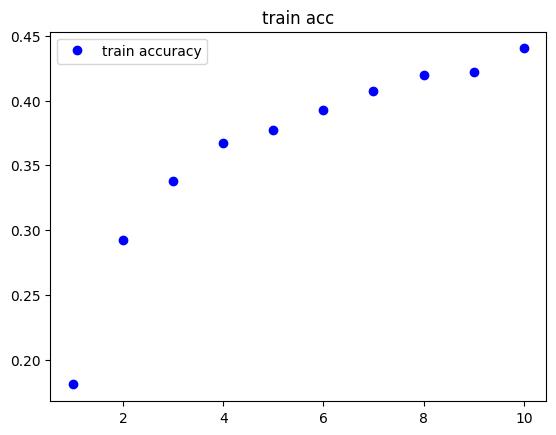

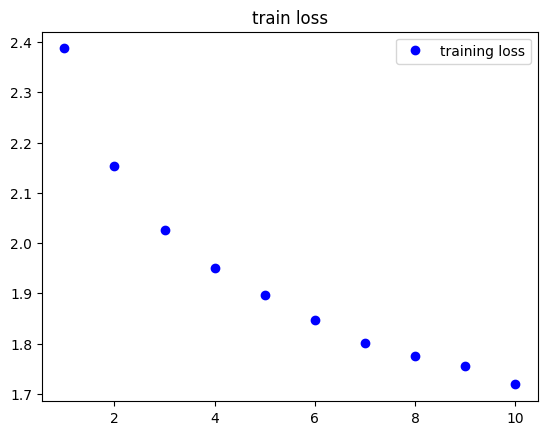

In [11]:
history = model2.fit(train_generator, 
				#steps_per_epoch = 65, 
				epochs = 10,)

acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.title('train acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.title('train loss')
plt.legend()

plt.show()

In [31]:
test_loss_vggr, test_acc_vggr = model2.evaluate(test_generator, steps = 25)
print('\ntest acc :\n', test_acc_vggr)

25/25 [==============================] - 20s 814ms/step - loss: 38.2173 - acc: 0.2620

test acc :
 0.2619999945163727


# Tercer Modelo

Con el fin de explrar más alternativas, se utilizó el mismo modelo anterior pero cambiando el *optimizer* por *Adam* para comparar resultados.

In [55]:
conv_base= VGG16(weights='imagenet',
				include_top = False,
				input_shape = (150,150,3))

conv_base.trainable = False

model3 = models.Sequential()
model3.add(conv_base)
model3.add(layers.Flatten())
model3.add(layers.Dense(256,activation='relu'))
model3.add(layers.Dense(12,activation='softmax'))

model3.summary()

model3.compile(loss='categorical_crossentropy',
						optimizer='adam',
						metrics=['acc'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 8192)              0         
                                                                 
 dense_14 (Dense)            (None, 256)               2097408   
                                                                 
 dense_15 (Dense)            (None, 12)                3084      
                                                                 
Total params: 16,815,180
Trainable params: 2,100,492
Non-trainable params: 14,714,688
_________________________________________________________________


Epoch 1/10
449/623 [====================>.........] - ETA: 1:09 - loss: 2.1929 - acc: 0.2738

c:\Users\quiqu\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\Image.py:2855: DecompressionBombWarning: Image size (91187250 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


623/623 [==============================] - 256s 410ms/step - loss: 2.1221 - acc: 0.2956
Epoch 2/10
623/623 [==============================] - 266s 426ms/step - loss: 1.8298 - acc: 0.3874
Epoch 3/10
623/623 [==============================] - 247s 396ms/step - loss: 1.7086 - acc: 0.4256
Epoch 4/10
623/623 [==============================] - 241s 387ms/step - loss: 1.6353 - acc: 0.4471
Epoch 5/10
623/623 [==============================] - 240s 385ms/step - loss: 1.5957 - acc: 0.4611
Epoch 6/10
623/623 [==============================] - 240s 386ms/step - loss: 1.5524 - acc: 0.4798
Epoch 7/10
623/623 [==============================] - 239s 384ms/step - loss: 1.5199 - acc: 0.4939
Epoch 8/10
623/623 [==============================] - 241s 387ms/step - loss: 1.4888 - acc: 0.4878
Epoch 9/10
623/623 [==============================] - 241s 387ms/step - loss: 1.4783 - acc: 0.4993
Epoch 10/10
623/623 [==============================] - 239s 384ms/step - loss: 1.4415 - acc: 0.5176


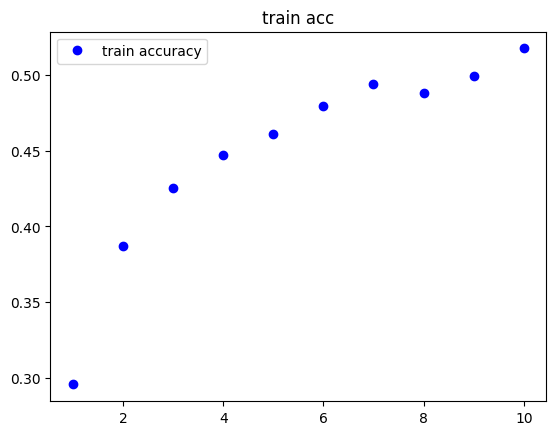

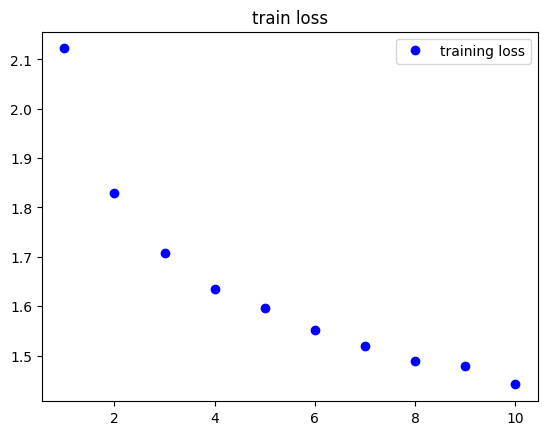

In [56]:
history = model3.fit(train_generator, 
				epochs = 10)

acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.title('train acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.title('train loss')
plt.legend()

plt.show()

In [60]:
test_loss_vgga, test_acc_vgga = model3.evaluate(test_generator, steps = 25)
print('\ntest acc :\n', test_acc_vgga)

25/25 [==============================] - 21s 841ms/step - loss: 71.1536 - acc: 0.2400

test acc :
 0.23999999463558197


# Reporte de resultados

In [106]:
data = {
    'Model': ['Base', 'VGG with RMS', 'VGG with Adam'],
    'test loss': [test_loss_base, test_loss_vggr, test_loss_vgga],
    'test accuracy': [test_acc_base, test_acc_vggr, test_acc_vgga],
    'train loss' : [2.0467, 1.7327, 1.4415],
    'train accuracy' : [0.3079, 0.4336, 0.5176]
}

results = pd.DataFrame(data)

results_show = results.style.hide_index()

results_show

Model,test loss,test accuracy,train loss,train accuracy
Base,249.853470,0.228000,2.046700,0.307900
VGG with RMS,32.320381,0.276000,1.732700,0.433600
VGG with Adam,71.153595,0.240000,1.441500,0.517600


De los 3 modelos realizados se observa que aquel que tuvo mejor rendimiento fue *VGG16* con el uso del *optimizer RMSprop*.

Si bien *VGG16* con *Adam* tuvo un 51.76% de precisión en el entrenamiento, éste decayó en las pruebas, siendo casi un 4% inferior a *VGG16* con *RMSprop*. Por lo que el más consistente es el **segundo modelo**.

In [32]:
test_datagen = ImageDataGenerator(1./255)
test_generator = test_datagen.flow_from_directory(
					test_dir,
					target_size = (150, 150),
					# batch_size = 20,
					class_mode= 'categorical')

Found 1252 images belonging to 12 classes.


Se elimina el *batch_size* para la prueba de la matriz de confusión con el fin que la función tenga más elementos para probar.

In [40]:
test_imgs = test_generator[0][0]
test_labels = test_generator[0][1]
test_labels_true = np.argmax(test_labels, axis=1)

predictions = model2.predict(test_imgs)
classes_x = np.argmax(predictions,axis=1)

classes_x

1/1 [==============================] - 1s 1s/step


array([ 7,  2,  0,  0,  0,  0,  2,  7,  0,  0,  7,  7,  0,  7,  7,  0,  0,
        0,  7,  0,  0,  2, 10,  0,  7,  0,  7,  0,  7,  7,  0,  2],
      dtype=int64)

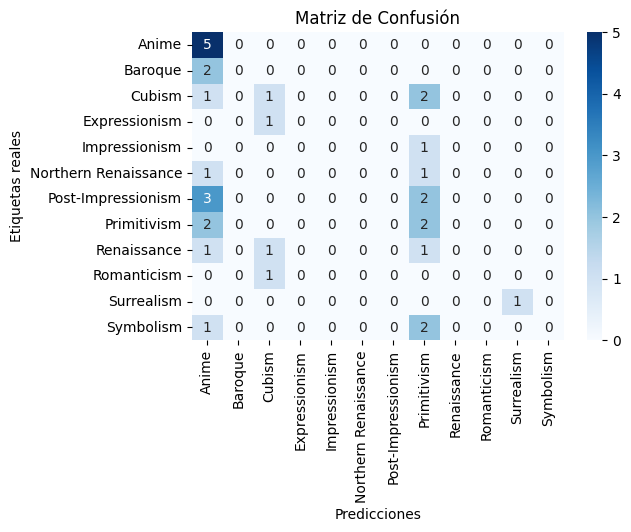

In [41]:
import seaborn as sns
from tensorflow.math import confusion_matrix

mat = confusion_matrix(test_labels_true, classes_x)
# Obtener las etiquetas de las clases
class_labels = test_generator.class_indices
class_labels = [k for k, v in sorted(class_labels.items(), key=lambda item: item[1])]

# Crear la figura y el eje de la gráfica
fig, ax = plt.subplots(figsize=(6, 4))

# Crear la matriz de confusión
sns.heatmap(mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, ax=ax)

ax.set_xlabel("Predicciones")
ax.set_ylabel("Etiquetas reales")
ax.set_title("Matriz de Confusión")

plt.show()

Aquí se observa la matriz confusión de las predicciones y etiquetas reales a través de un mapa de calor.

Se puede ver una clara inclinación hacia los géneros de *Anime* y *Privitivism*, mayormete al *Anime*. Esto puede deberse nuevamente al *accuracy* relativamente bajo del modelo y a la complejidad de los datos. Además, tanto en las imágenes de *Anime* como en las de *Privitivism* se aprecia una mayor cantidad de colores vistosos y definidos, por lo que pueden ser fácilmente identificables y relacionables en comparación a los otros géneros con paletas de colores similares que pueden confundirse fácilmente.

Podríamos explorar modelos más complejos o incrementar el set de datos con el fin de hacer a cada clase más fácil de identificar y mejorar el rendimiento de modelo.

# Guardado de modelos

In [107]:
model.save('modelo_Base.h5')
model2.save('modelo_VGG_RMS.h5')
model3.save('modelo_VGG_Adam.h5')